<a href="https://colab.research.google.com/github/shin-ta/Python-study/blob/main/%E3%81%8A%E5%BC%81%E5%BD%93%E5%A3%B2%E4%B8%8A%E4%BA%88%E6%B8%AC_%E3%83%81%E3%83%A5%E3%83%BC%E3%83%88%E3%83%AA%E3%82%A2%E3%83%AB_%E6%94%B9%E9%80%A0%E7%89%88.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ライブラリをインポート
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(font='IPAexGothic', style='white')
# ウォーニングを非表示にする
import warnings
warnings.filterwarnings('ignore')

# **時間経過とともに右肩下がりとなるトレンドによる売上を予測**

In [ ]:
# SIGNATEからダウンロードしたデータをデータフレームに読み込み
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample = pd.read_csv('sample.csv',header=None)

In [ ]:
# 弁当の売上げ（[y]）をグラフで表示
train.index = pd.to_datetime(train['datetime'])
train['y'].plot(figsize=(15,4))

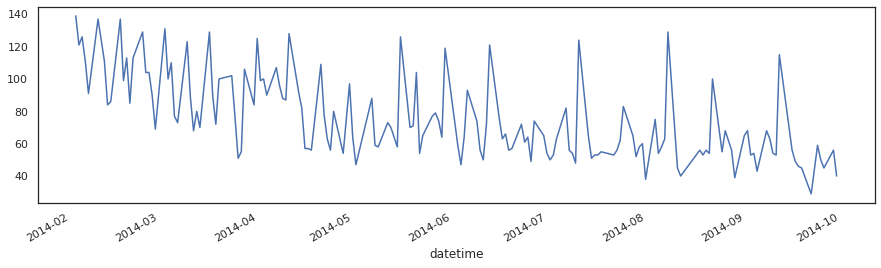

In [ ]:
# 「2014-02-01」以降のデータを取得する
train = train['2014-02-01':]
train['y'].plot(figsize=(15,4))
train = train.reset_index(drop=True)

In [ ]:
# 学習用データとテスト用データを区別するフラグを付加してデータを結合する
train['t'] = 1
test['t'] = 0
dat = pd.concat([train, test],sort=True).reset_index(drop=True)

In [ ]:
# 経過日数列を追加
dat['days'] = dat.index

In [ ]:
# 結合したデータを学習用データとテスト用データに分割する
train = dat[dat['t'] == 1]
test = dat[dat['t'] == 0]
test = test.drop('y', axis=1)

In [ ]:
# トレンド売上予測の説明変数（経過日数）と目的変数を取得
X_train_CF = train['days']
y_train_CF = train['y']

X_test_CF = test['days']

In [ ]:
# カーブフィットにて学習用データのトレンド売上を予測
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a * np.exp(-b * x) + c

xs = X_train_CF.values
ys = y_train_CF.values

popt, pcov = curve_fit(func, xs, ys)

a1, b1, c1 = popt
pred_train_CF = a1 * np.exp(-b1 * xs) + c1

p = pd.DataFrame({"actual":y_train_CF, "pred":pred_train_CF})
p.plot(figsize=(15,4))

In [ ]:
# カーブフィットにてテスト用データのトレンド売上を予測
xs = X_test_CF.values
pred_test_CF = a1 * np.exp(-b1 * xs) + c1

In [ ]:
print(pred_train_CF)
print(pred_test_CF)

# **実売上からトレンドによる売上を控除した非トレンド売上を予測**

In [ ]:
# 実売上とトレンドによる売上予測の差分を新たな目的変数とする
train['y2'] = train['y'] - pred_train_TR

In [ ]:
p = pd.DataFrame(train['y2'])
p.plot(figsize=(15,4))

In [ ]:
# 学習用データとテスト用データを区別するフラグを付加してデータを結合する
dat = pd.concat([train, test])

**前処理実行**

In [ ]:
# 前処理①　欠損値補完
dat['kcal'] = dat['kcal'].fillna(dat['kcal'].mean())
dat['payday'] = dat['payday'].fillna(0)

In [ ]:
# 前処理②　新特徴量（お楽しみメニュー）作成
dat['fun'] = dat['remarks'].apply(lambda x: 1 if x=='お楽しみメニュー' else 0)


In [ ]:
plt.figure(figsize=(15,6))
sns.boxplot(x='fun', y='y2', data=dat)

In [ ]:
# 前処理③　新特徴量（カレー）作成
dat['curry'] = dat['name'].apply(lambda x : 1 if x.find('カレー')>=0 else 0)

In [ ]:
plt.figure(figsize=(15,6))
sns.boxplot(x='curry', y='y2', data=dat)

In [ ]:
# 前処理④　新特徴量（日付）作成
dat['day'] = dat['datetime'].apply(lambda x : int(x.split("-")[2]))

In [ ]:
plt.figure(figsize=(15,6))
sns.boxplot(x='day', y='y2', data=dat)

In [ ]:
# 前処理⑤　新特徴量（人気メニュー）作成
popular_menu = set(dat[dat['y2']>15].name)
dat['popular'] = dat['name'].apply(lambda x : 1 if x in popular_menu else 0)

In [ ]:
plt.figure(figsize=(15,6))
sns.boxplot(x='popular', y='y2', data=dat)

In [ ]:
# 前処理⑥　新特徴量（不人気メニュー）作成
unpopular_menu = set(dat[dat['y2']<-15].name)
dat['unpopular'] = dat['name'].apply(lambda x : 1 if x in unpopular_menu else 0)

In [ ]:
plt.figure(figsize=(15,6))
sns.boxplot(x='unpopular', y='y2', data=dat)

In [ ]:
# 前処理⑦　新特徴量（月平均気温差異）作成
dat['month'] = dat['datetime'].apply(lambda x : int(x.split("-")[1]))
temp_mean = dat.groupby('month').temperature.mean()
dat['month'] =  dat['month'].replace(temp_mean)
dat['temp'] = dat['temperature'] - dat['month']

In [ ]:
# 前処理⑧　カテゴリ値（曜日）を数値に置き換え
dat['week'] = dat['week'].replace('月', 1)
dat['week'] = dat['week'].replace('火', 2)
dat['week'] = dat['week'].replace('水', 3)
dat['week'] = dat['week'].replace('木', 4)
dat['week'] = dat['week'].replace('金', 5)

In [ ]:
plt.figure(figsize=(15,6))
sns.boxplot(x='week', y='y2', data=dat)

In [ ]:
# 前処理⑨　カテゴリ値（天候）を数値に置き換え
dat['weather'] = dat['weather'].replace('快晴', 1)
dat['weather'] = dat['weather'].replace('晴れ', 2)
dat['weather'] = dat['weather'].replace('薄曇', 3)
dat['weather'] = dat['weather'].replace('曇', 4)
dat['weather'] = dat['weather'].replace('雨', 5)
dat['weather'] = dat['weather'].replace('雷電', 6)
dat['weather'] = dat['weather'].replace('雪', 7)

In [ ]:
plt.figure(figsize=(15,6))
sns.boxplot(x='weather', y='y2', data=dat)

In [ ]:
# 前処理⑩　カテゴリ値（降水量）を数値に置き換え
dat['precipitation'] = dat['precipitation'].apply(lambda x : -1 if x=='--' else x).astype(np.float)

In [ ]:
plt.figure(figsize=(15,6))
sns.boxplot(x='precipitation', y='y2', data=dat)

In [ ]:
# 前処理⑪　不要列削除
dat = dat.drop(['datetime', 'days', 'event', 'month', 'name', 'remarks', 'temperature', 'y'], axis=1)

In [ ]:
# 結合したデータを学習用データとテスト用データに分割する
train = dat[dat['t'] == 1]
train = train.drop('t', axis=1)
test = dat[dat['t'] == 0]
test = test.drop(['t', 'y2'], axis=1)

**非トレンド売上を予測するモデル作成**

In [ ]:
# 学習用データを目的変数と説明変数に分割
y = train['y2']                 # 目的変数
X = train.drop(['y2'], axis=1)  # 説明変数（目的変数を除いたデータ）

In [ ]:
# ランダムフォレストを用いて特徴量の重要度確認
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.metrics import mean_squared_error as MSE
model_RF = RF(random_state=0)
model_RF.fit(X, y)

fti = model_RF.feature_importances_

print('Feature Importances:')
for i, feat in enumerate(X):
    print('\t{0:10s} : {1:>.6f}'.format(feat, fti[i]))

In [ ]:
# 重要度の低い特徴量削除
X = X.drop(['payday', 'precipitation', 'soldout', 'weather', 'curry'], axis=1)
test = test.drop(['payday', 'precipitation', 'soldout', 'weather', 'curry'], axis=1)

In [ ]:
# 学習用データをモデル訓練用とモデル検証用に分割
from sklearn.model_selection import train_test_split
X_train_RF, X_test_RF, y_train_RF, y_test_RF = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
# グリッドサーチで最良のパラメータの組み合わせを取得
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.model_selection import KFold

# パラメータ候補を辞書型で設定
param = {'max_depth':[2, 3, 4, 5, 6],                   # デフォルト値：None
         'min_samples_split':[2, 3, 4, 5, 6, 7],        # デフォルト値：2
         'n_estimators':[95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110],      # デフォルト値：100
         'random_state':[0]}

# ランダムフォレストによる学習
cv = 5
clf = GridSearchCV(RF(), param, cv=cv)
clf.fit(X_train_RF,y_train_RF)                           
 
# 結果の確認
print('最良条件:\n', clf.best_estimator_)
print('最良スコア:\n',clf.best_score_)

In [ ]:
# 最良パラメータのランダムフォレストでモデリング test_size=0.2
from sklearn.metrics import mean_squared_error as MSE
model_RF = RF(max_depth=5, min_samples_split=5, n_estimators=108,
                      random_state=0)
model_RF.fit(X_train_RF, y_train_RF)

# 評価実行
pred_train = model_RF.predict(X_train_RF)
pred_test = model_RF.predict(X_test_RF)
print("訓練データによる評価: ",MSE(y_train_RF,pred_train)**0.5)
print("検証データによる評価: ",MSE(y_test_RF,pred_test)**0.5)

In [ ]:
# 学習用データで予測実行
pred_train_RF = model_RF.predict(X)

In [ ]:
# 予測結果と目的変数を比較
p = pd.DataFrame({"actual":y, "pred":pred_train_RF})
p.plot(figsize=(15,4))

# **テストデータで予測実行**

In [ ]:
# テストデータで非トレンド売上を予測
pred_test_RF = model_RF.predict(test)

In [ ]:
# トレンド売上予測と非トレンド売上予測を合算
pred = pred_test_CF + pred_test_RF

In [ ]:
# テストデータの予測結果を投稿用データに設定してファイル出力
sample[1] = pred
sample.to_csv("submit0720_03.csv",index=None,header=None)